In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import os
import zipfile
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflowjs as tfjs
from sklearn.model_selection import train_test_split
import random
import glob

In [3]:
# --- 0. Persiapan Direktori (Jalankan ini sekali di awal sesi Colab) ---
print("--- 0. Persiapan Direktori ---")
# Hapus direktori lama jika ada dari sesi sebelumnya untuk menghindari konflik
if os.path.exists('vegetable_data'):
    shutil.rmtree('vegetable_data')
if os.path.exists('combined_data'):
    shutil.rmtree('combined_data')
if os.path.exists('split_data'):
    shutil.rmtree('split_data')
if os.path.exists('submission'):
    shutil.rmtree('submission')
print("Direktori lama telah dibersihkan (jika ada).")

--- 0. Persiapan Direktori ---
Direktori lama telah dibersihkan (jika ada).


In [4]:
# --- 1. Unduh dan Ekstrak Dataset ---
print("--- 1. Mengunduh dan Mengekstrak Dataset ---")

import gdown
drive_id = '1a-kbzH0hzNx1s-3j5q5LC11xpI_7MB4H'
output_path = 'vegetable.zip'
gdown.download(id=drive_id, output=output_path, quiet=False)



--- 1. Mengunduh dan Mengekstrak Dataset ---


Downloading...
From (original): https://drive.google.com/uc?id=1a-kbzH0hzNx1s-3j5q5LC11xpI_7MB4H
From (redirected): https://drive.google.com/uc?id=1a-kbzH0hzNx1s-3j5q5LC11xpI_7MB4H&confirm=t&uuid=971111a7-9103-48a8-99bd-c5afdef76243
To: /content/vegetable.zip
100%|██████████| 560M/560M [00:09<00:00, 56.9MB/s]


'vegetable.zip'

In [5]:
import os
import zipfile
zip_path = 'vegetable.zip'
extract_dir = 'vegetable_data'

if not os.path.exists(zip_path):
    print(f"Error: File ZIP tidak ditemukan di '{zip_path}'. Pastikan Anda sudah mengunggahnya ke sesi Colab.")
    print("Silakan unggah 'vegetabl.zip' ke sesi Colab Anda (melalui menu File -> Upload to session storage, atau ikon folder di sidebar kiri).")
    exit()
else:
    print(f"Mengekstrak {zip_path} ke {extract_dir}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Ekstraksi selesai.")

    # Dataset ini biasanya memiliki 'Vegetable Images' di dalam extract_dir
    original_train_dir = os.path.join(extract_dir, 'Vegetable Images', 'train')
    original_validation_dir = os.path.join(extract_dir, 'Vegetable Images', 'validation')

    if not os.path.exists(original_train_dir) or not os.path.exists(original_validation_dir):
        print("Peringatan: Struktur direktori dataset tidak sesuai harapan. Pastikan 'Vegetable Images/train' dan 'Vegetable Images/validation' ada.")
        # Coba asumsikan langsung di dalam extract_dir jika tidak ada subfolder 'Vegetable Images'
        original_train_dir = os.path.join(extract_dir, 'train')
        original_validation_dir = os.path.join(extract_dir, 'validation')
        if not os.path.exists(original_train_dir) or not os.path.exists(original_validation_dir):
            print("ERROR: Direktori training atau validation asli tidak ditemukan.")
            exit()
    print(f"Direktori data asli Train: {original_train_dir}")
    print(f"Direktori data asli Validation: {original_validation_dir}")

Mengekstrak vegetable.zip ke vegetable_data...
Ekstraksi selesai.
Direktori data asli Train: vegetable_data/Vegetable Images/train
Direktori data asli Validation: vegetable_data/Vegetable Images/validation


In [6]:
# --- 2. Menggabungkan dan Membagi Dataset (Train, Validation, Test) ---
print("\n--- 2. Menggabungkan dan Membagi Dataset secara Mandiri ---")

combined_data_dir = 'combined_data'
os.makedirs(combined_data_dir, exist_ok=True)

print("Menggabungkan gambar dari Train dan Validation asli...")
all_image_paths = []
all_image_labels = []

for original_dir in [original_train_dir, original_validation_dir]:
    for class_name in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_name)
        if os.path.isdir(class_path):
            target_class_dir = os.path.join(combined_data_dir, class_name)
            os.makedirs(target_class_dir, exist_ok=True)

            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    src_path = os.path.join(class_path, img_name)
                    dest_path = os.path.join(target_class_dir, img_name)
                    if not os.path.exists(dest_path):
                        shutil.copy(src_path, dest_path)
                        all_image_paths.append(dest_path)
                        all_image_labels.append(class_name)

print(f"Total gambar yang digabungkan: {len(all_image_paths)}")

if len(all_image_paths) < 1000:
    print("Peringatan: Jumlah gambar setelah digabungkan kurang dari 1000. Pastikan dataset memenuhi kriteria.")
if len(all_image_paths) < 10000:
    print("Saran: Untuk nilai tinggi, pertimbangkan dataset dengan minimal 10000 gambar.")


--- 2. Menggabungkan dan Membagi Dataset secara Mandiri ---
Menggabungkan gambar dari Train dan Validation asli...
Total gambar yang digabungkan: 18000


In [7]:
class_names = sorted(os.listdir(combined_data_dir))
class_names = [d for d in class_names if os.path.isdir(os.path.join(combined_data_dir, d))]
num_classes = len(class_names)
print(f"Nama-nama kelas yang terdeteksi: {class_names}")
print(f"Jumlah kelas yang terdeteksi: {num_classes}")
if num_classes < 3:
    print("Saran: Untuk nilai tinggi, pertimbangkan dataset dengan minimal 3 kelas.")

Nama-nama kelas yang terdeteksi: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
Jumlah kelas yang terdeteksi: 15


In [8]:
# Bagi dataset menjadi Train, Validation, dan Test (misal: 80% Train, 10% Validation, 10% Test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    all_image_paths, all_image_labels, test_size=0.1, stratify=all_image_labels, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=(0.1 / 0.9), stratify=y_train_val, random_state=42
)

print(f"Jumlah gambar Train: {len(X_train)}")
print(f"Jumlah gambar Validation: {len(X_val)}")
print(f"Jumlah gambar Test: {len(X_test)}")

Jumlah gambar Train: 14399
Jumlah gambar Validation: 1801
Jumlah gambar Test: 1800


In [9]:
split_data_dir = 'split_data'
train_dir = os.path.join(split_data_dir, 'train')
validation_dir = os.path.join(split_data_dir, 'validation')
test_dir = os.path.join(split_data_dir, 'test')

for directory in [train_dir, validation_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    for class_name in class_names:
        os.makedirs(os.path.join(directory, class_name), exist_ok=True)

print("Memindahkan gambar ke struktur folder Train/Validation/Test baru...")
for i, path in enumerate(X_train):
    class_name = y_train[i]
    shutil.copy(path, os.path.join(train_dir, class_name, os.path.basename(path)))

for i, path in enumerate(X_val):
    class_name = y_val[i]
    shutil.copy(path, os.path.join(validation_dir, class_name, os.path.basename(path)))

for i, path in enumerate(X_test):
    class_name = y_test[i]
    shutil.copy(path, os.path.join(test_dir, class_name, os.path.basename(path)))

print("Pembagian dataset selesai dan gambar telah dipindahkan.")

Memindahkan gambar ke struktur folder Train/Validation/Test baru...
Pembagian dataset selesai dan gambar telah dipindahkan.


In [10]:
# --- 3. Memeriksa Ukuran Gambar Sampel (dari combined_data_dir) ---
print("\n--- 3. Memeriksa Ukuran Gambar Sampel ---")
sample_image_sizes = []
sample_count = 0
for class_name in class_names:
    class_path = os.path.join(combined_data_dir, class_name)
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    sample_image_sizes.append(img.size)
                sample_count += 1
                if sample_count >= 10: break
            except Exception as e: print(f"Gagal membaca gambar {img_path}: {e}")
    if sample_count >= 10: break

print("Ukuran 10 Gambar Sampel (Width, Height):")
for size in sample_image_sizes: print(size)


--- 3. Memeriksa Ukuran Gambar Sampel ---
Ukuran 10 Gambar Sampel (Width, Height):
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)



--- 4. Visualisasi Jumlah Gambar per Kelas (Training Set Baru) ---


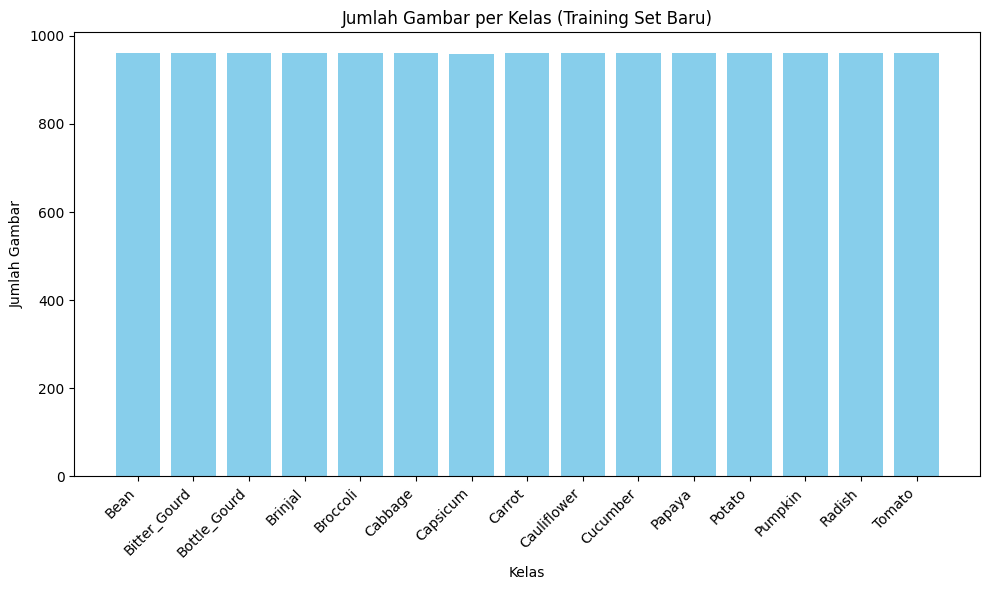

In [11]:
# --- 4. Visualisasi Jumlah Gambar pada Masing-masing Kelas (Training Set Baru) ---
print("\n--- 4. Visualisasi Jumlah Gambar per Kelas (Training Set Baru) ---")
train_class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
if train_class_counts:
    classes_list_plot = list(train_class_counts.keys())
    counts_plot = list(train_class_counts.values())
    plt.figure(figsize=(10, 6))
    plt.bar(classes_list_plot, counts_plot, color='skyblue')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.title('Jumlah Gambar per Kelas (Training Set Baru)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [12]:
# --- 5. Definisikan Parameter Gambar ---
print("\n--- 5. Mendefinisikan Parameter Gambar ---")
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
print(f"Ukuran Gambar Target (Height, Width): ({IMG_HEIGHT}, {IMG_WIDTH})")
print(f"Ukuran Batch: {BATCH_SIZE}")


--- 5. Mendefinisikan Parameter Gambar ---
Ukuran Gambar Target (Height, Width): (224, 224)
Ukuran Batch: 32


In [13]:
# --- 6. Augmentasi Gambar dan Normalisasi Gambar (Menggunakan ImageDataGenerator) ---
print("\n--- 6. Mengatur Image Data Generator (Augmentasi & Normalisasi) ---")

# ImageDataGenerator untuk Training dengan AUGMENTASI & NORMALISASI
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalisasi piksel ke [0,1]
    rotation_range=20,        # Rotasi gambar secara acak hingga 20 derajat
    width_shift_range=0.2,    # Geser gambar secara horizontal
    height_shift_range=0.2,   # Geser gambar secara vertikal
    shear_range=0.2,          # Menerapkan shear transformation
    zoom_range=0.2,           # Menerapkan zoom secara acak
    horizontal_flip=True,     # Membalik gambar secara horizontal
    fill_mode='nearest'       # Mengisi piksel yang hilang setelah transformasi
)



--- 6. Mengatur Image Data Generator (Augmentasi & Normalisasi) ---


In [14]:
# ImageDataGenerator untuk Validation dan Test HANYA untuk NORMALISASI
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Penting agar urutan prediksi cocok dengan label sebenarnya jika ingin classification_report
)

Found 14399 images belonging to 15 classes.
Found 1801 images belonging to 15 classes.
Found 1800 images belonging to 15 classes.



--- 7. Menampilkan Sampel Gambar (dengan Augmentasi) ---


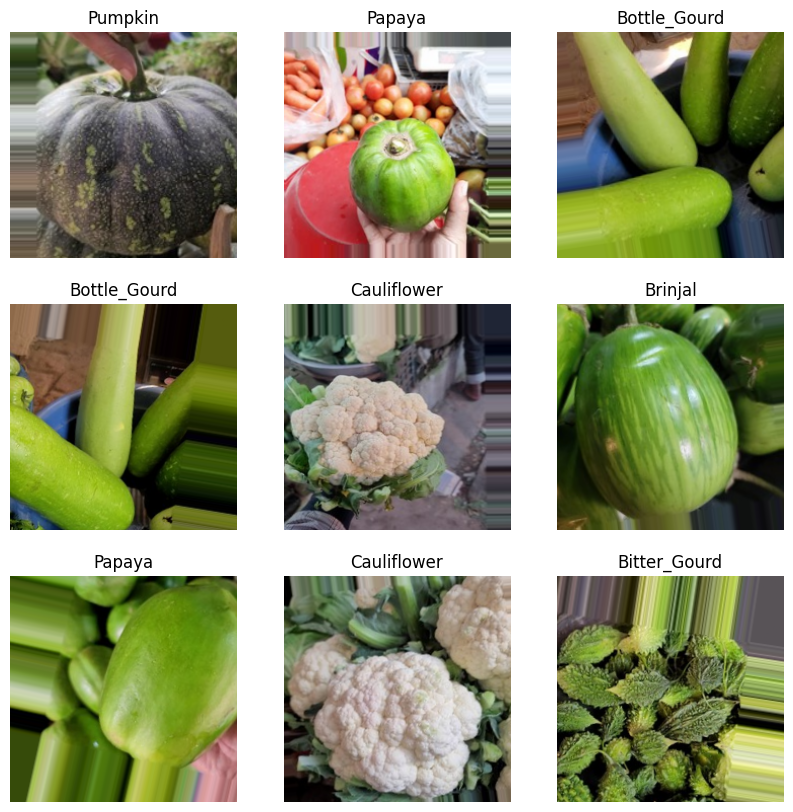

In [15]:
# --- 7. Menampilkan 6 atau 9 Sampel Gambar ---
print("\n--- 7. Menampilkan Sampel Gambar (dengan Augmentasi) ---")
# Mengambil satu batch dari training generator (sudah teraugmentasi dan ternormalisasi)
images_augmented, labels_augmented = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(min(9, len(images_augmented))):
    ax = plt.subplot(3, 3, i + 1)
    # matplotlib akan otomatis meng-klip data jika rentang tidak persis [0,1] atau [0,255]
    # Peringatan "Clipping input data" mungkin masih muncul sesekali karena augmentasi
    # mengubah rentang nilai piksel sedikit, tapi itu normal dan tidak masalah.
    plt.imshow(images_augmented[i])
    label_index = np.argmax(labels_augmented[i])
    class_name_from_gen = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(label_index)]
    plt.title(class_name_from_gen)
    plt.axis('off')
plt.show()


In [16]:
# --- 8. Membangun Model CNN (Sequential, Conv2D, Pooling Layer) ---
print("\n--- 8. Membangun Model CNN ---")
model = tf.keras.Sequential([
    # Input layer tanpa rescaling, karena rescaling sudah dilakukan oleh ImageDataGenerator
    tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    # Hapus lapisan data_augmentation karena augmentasi sudah dilakukan oleh ImageDataGenerator
    # Hapus lapisan Rescaling karena sudah dilakukan oleh ImageDataGenerator
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


--- 8. Membangun Model CNN ---


In [17]:
# --- 9. Kompilasi Model (Optimalisasi) ---
print("\n--- 9. Kompilasi Model (Optimalisasi) ---")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


--- 9. Kompilasi Model (Optimalisasi) ---


In [18]:
# --- 10. Menampilkan Ringkasan Model ---
print("\n--- 10. Menampilkan Ringkasan Model ---")
model.summary()


--- 10. Menampilkan Ringkasan Model ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     9,437,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,990,223 (41.92 MB)

 Trainable params: 10,990,223 (41.92 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# --- 11. Mengimplementasikan Callback ---
print("\n--- 11. Mengimplementasikan Callback ---")
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks_list = [early_stopping, model_checkpoint, reduce_lr]


--- 11. Mengimplementasikan Callback ---


In [20]:
# --- 12. Melatih Model ---
print("\n--- 12. Melatih Model ---")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)
model.load_weights('best_model.h5')
print("\nModel terbaik berhasil dimuat dari 'best_model.h5'")


--- 12. Melatih Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.1673 - loss: 2.5022
Epoch 1: val_accuracy improved from -inf to 0.45368, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 220s 454ms/step - accuracy: 0.1675 - loss: 2.5016 - val_accuracy: 0.4537 - val_loss: 1.6263 - learning_rate: 5.0000e-04
Epoch 2/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 57s 129ms/step - accuracy: 0.3125 - loss: 2.0279

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.45368 to 0.45536, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3125 - loss: 2.0279 - val_accuracy: 0.4554 - val_loss: 1.6392 - learning_rate: 5.0000e-04
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.4041 - loss: 1.7078
Epoch 3: val_accuracy improved from 0.45536 to 0.69922, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 262s 493ms/step - accuracy: 0.4042 - loss: 1.7075 - val_accuracy: 0.6992 - val_loss: 1.0158 - learning_rate: 5.0000e-04
Epoch 4/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 120ms/step - accuracy: 0.4688 - loss: 1.7738
Epoch 4: val_accuracy did not improve from 0.69922
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4688 - loss: 1.7738 - val_accuracy: 0.6473 - val_loss: 1.0931 - learning_rate: 5.0000e-04
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.5871 - loss: 1.2446
Epoch 5: val_accuracy did not improve from 0.69922
449/449 ━━━━━━━━━━━━━━━━━━━━ 262s 501ms/step - accuracy: 0.5871 - loss: 1.2444 - val_accuracy: 0.6914 - val_loss: 0.9026 - learning_rate: 5.0000e-04
Epoch 6/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - accuracy: 0.6875 - loss: 0.8850
Epoch 6: val_accuracy did not improve from 0.69922
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6875 - loss: 0.8850 - val_accuracy: 0.6920 - val_loss: 0.8996 - learning_rate: 5.00

449/449 ━━━━━━━━━━━━━━━━━━━━ 203s 451ms/step - accuracy: 0.6622 - loss: 1.0172 - val_accuracy: 0.7500 - val_loss: 0.7766 - learning_rate: 5.0000e-04
Epoch 8/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - accuracy: 0.6875 - loss: 1.0742
Epoch 8: val_accuracy improved from 0.75000 to 0.75837, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6875 - loss: 1.0742 - val_accuracy: 0.7584 - val_loss: 0.7545 - learning_rate: 5.0000e-04
Epoch 9/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7251 - loss: 0.8414
Epoch 9: val_accuracy improved from 0.75837 to 0.82310, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 262s 462ms/step - accuracy: 0.7251 - loss: 0.8413 - val_accuracy: 0.8231 - val_loss: 0.5604 - learning_rate: 5.0000e-04
Epoch 10/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - accuracy: 0.6562 - loss: 0.8252
Epoch 10: val_accuracy improved from 0.82310 to 0.82757, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6562 - loss: 0.8252 - val_accuracy: 0.8276 - val_loss: 0.5417 - learning_rate: 5.0000e-04
Epoch 11/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.7661 - loss: 0.7219
Epoch 11: val_accuracy improved from 0.82757 to 0.86775, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 235s 415ms/step - accuracy: 0.7661 - loss: 0.7218 - val_accuracy: 0.8677 - val_loss: 0.4585 - learning_rate: 5.0000e-04
Epoch 12/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - accuracy: 0.7500 - loss: 0.8738
Epoch 12: val_accuracy did not improve from 0.86775
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7500 - loss: 0.8738 - val_accuracy: 0.8633 - val_loss: 0.4568 - learning_rate: 5.0000e-04
Epoch 13/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.7957 - loss: 0.6403
Epoch 13: val_accuracy improved from 0.86775 to 0.87891, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 198s 415ms/step - accuracy: 0.7957 - loss: 0.6403 - val_accuracy: 0.8789 - val_loss: 0.4256 - learning_rate: 5.0000e-04
Epoch 14/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - accuracy: 0.8125 - loss: 0.6632
Epoch 14: val_accuracy improved from 0.87891 to 0.88225, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8125 - loss: 0.6632 - val_accuracy: 0.8823 - val_loss: 0.4243 - learning_rate: 5.0000e-04
Epoch 15/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8265 - loss: 0.5463
Epoch 15: val_accuracy did not improve from 0.88225
449/449 ━━━━━━━━━━━━━━━━━━━━ 195s 414ms/step - accuracy: 0.8265 - loss: 0.5463 - val_accuracy: 0.7935 - val_loss: 0.8030 - learning_rate: 5.0000e-04
Epoch 16/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 120ms/step - accuracy: 0.8125 - loss: 0.5600
Epoch 16: val_accuracy did not improve from 0.88225
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8125 - loss: 0.5600 - val_accuracy: 0.8047 - val_loss: 0.7221 - learning_rate: 5.0000e-04
Epoch 17/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8314 - loss: 0.5277
Epoch 17: val_accuracy improved from 0.88225 to 0.92020, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 203s 451ms/step - accuracy: 0.8315 - loss: 0.5276 - val_accuracy: 0.9202 - val_loss: 0.2694 - learning_rate: 5.0000e-04
Epoch 18/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - accuracy: 0.8438 - loss: 0.4518
Epoch 18: val_accuracy did not improve from 0.92020
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8438 - loss: 0.4518 - val_accuracy: 0.9096 - val_loss: 0.2997 - learning_rate: 5.0000e-04
Epoch 19/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8571 - loss: 0.4659
Epoch 19: val_accuracy did not improve from 0.92020
449/449 ━━━━━━━━━━━━━━━━━━━━ 186s 413ms/step - accuracy: 0.8571 - loss: 0.4659 - val_accuracy: 0.8594 - val_loss: 0.4890 - learning_rate: 5.0000e-04
Epoch 20/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - accuracy: 0.8125 - loss: 0.4973
Epoch 20: val_accuracy did not improve from 0.92020
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8125 - loss: 0.4973 - val_accuracy: 0.8410 - val_loss: 0.5627 - learning_rate

449/449 ━━━━━━━━━━━━━━━━━━━━ 202s 420ms/step - accuracy: 0.8658 - loss: 0.4225 - val_accuracy: 0.9275 - val_loss: 0.2629 - learning_rate: 5.0000e-04
Epoch 22/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - accuracy: 0.8438 - loss: 0.6232
Epoch 22: val_accuracy did not improve from 0.92746
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8438 - loss: 0.6232 - val_accuracy: 0.9235 - val_loss: 0.2863 - learning_rate: 5.0000e-04
Epoch 23/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8777 - loss: 0.3904
Epoch 23: val_accuracy improved from 0.92746 to 0.93415, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 202s 428ms/step - accuracy: 0.8777 - loss: 0.3904 - val_accuracy: 0.9342 - val_loss: 0.2411 - learning_rate: 5.0000e-04
Epoch 24/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - accuracy: 0.8750 - loss: 0.3454
Epoch 24: val_accuracy improved from 0.93415 to 0.93917, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8750 - loss: 0.3454 - val_accuracy: 0.9392 - val_loss: 0.2171 - learning_rate: 5.0000e-04
Epoch 25/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8908 - loss: 0.3557
Epoch 25: val_accuracy improved from 0.93917 to 0.94308, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 199s 442ms/step - accuracy: 0.8908 - loss: 0.3557 - val_accuracy: 0.9431 - val_loss: 0.2061 - learning_rate: 5.0000e-04
Epoch 26/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 120ms/step - accuracy: 0.9062 - loss: 0.1614
Epoch 26: val_accuracy did not improve from 0.94308
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9062 - loss: 0.1614 - val_accuracy: 0.9420 - val_loss: 0.2089 - learning_rate: 5.0000e-04
Epoch 27/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8947 - loss: 0.3464
Epoch 27: val_accuracy did not improve from 0.94308
449/449 ━━━━━━━━━━━━━━━━━━━━ 202s 450ms/step - accuracy: 0.8946 - loss: 0.3464 - val_accuracy: 0.9386 - val_loss: 0.2144 - learning_rate: 5.0000e-04
Epoch 28/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 120ms/step - accuracy: 0.9062 - loss: 0.1893
Epoch 28: val_accuracy did not improve from 0.94308
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9062 - loss: 0.1893 - val_accuracy: 0.9291 - val_loss: 0.2393 - learning_rate

449/449 ━━━━━━━━━━━━━━━━━━━━ 186s 413ms/step - accuracy: 0.9254 - loss: 0.2529 - val_accuracy: 0.9587 - val_loss: 0.1454 - learning_rate: 1.0000e-04
Epoch 32/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.9062 - loss: 0.2774
Epoch 32: val_accuracy improved from 0.95871 to 0.96038, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9062 - loss: 0.2774 - val_accuracy: 0.9604 - val_loss: 0.1437 - learning_rate: 1.0000e-04
Epoch 33/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9401 - loss: 0.1967
Epoch 33: val_accuracy improved from 0.96038 to 0.96708, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 198s 413ms/step - accuracy: 0.9401 - loss: 0.1968 - val_accuracy: 0.9671 - val_loss: 0.1282 - learning_rate: 1.0000e-04
Epoch 34/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - accuracy: 0.9688 - loss: 0.1474
Epoch 34: val_accuracy did not improve from 0.96708
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9688 - loss: 0.1474 - val_accuracy: 0.9671 - val_loss: 0.1297 - learning_rate: 1.0000e-04
Epoch 35/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9412 - loss: 0.1873
Epoch 35: val_accuracy improved from 0.96708 to 0.97210, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 202s 420ms/step - accuracy: 0.9412 - loss: 0.1873 - val_accuracy: 0.9721 - val_loss: 0.0989 - learning_rate: 1.0000e-04
Epoch 36/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - accuracy: 1.0000 - loss: 0.0345
Epoch 36: val_accuracy did not improve from 0.97210
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 1.0000 - loss: 0.0345 - val_accuracy: 0.9710 - val_loss: 0.1004 - learning_rate: 1.0000e-04
Epoch 37/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9456 - loss: 0.1786
Epoch 37: val_accuracy did not improve from 0.97210
449/449 ━━━━━━━━━━━━━━━━━━━━ 202s 450ms/step - accuracy: 0.9456 - loss: 0.1786 - val_accuracy: 0.9671 - val_loss: 0.1280 - learning_rate: 1.0000e-04
Epoch 38/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - accuracy: 0.9375 - loss: 0.1765
Epoch 38: val_accuracy did not improve from 0.97210
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9375 - loss: 0.1765 - val_accuracy: 0.9693 - val_loss: 0.1189 - learning_rate

449/449 ━━━━━━━━━━━━━━━━━━━━ 203s 451ms/step - accuracy: 0.9457 - loss: 0.1804 - val_accuracy: 0.9805 - val_loss: 0.0785 - learning_rate: 1.0000e-04
Epoch 40/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - accuracy: 1.0000 - loss: 0.0461
Epoch 40: val_accuracy did not improve from 0.98047
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 1.0000 - loss: 0.0461 - val_accuracy: 0.9782 - val_loss: 0.0831 - learning_rate: 1.0000e-04
Epoch 41/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9498 - loss: 0.1595
Epoch 41: val_accuracy did not improve from 0.98047
449/449 ━━━━━━━━━━━━━━━━━━━━ 202s 451ms/step - accuracy: 0.9498 - loss: 0.1595 - val_accuracy: 0.9749 - val_loss: 0.0983 - learning_rate: 1.0000e-04
Epoch 42/50
  1/449 ━━━━━━━━━━━━━━━━━━━━ 53s 120ms/step - accuracy: 0.9375 - loss: 0.1162
Epoch 42: val_accuracy did not improve from 0.98047
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9375 - loss: 0.1162 - val_accuracy: 0.9738 - val_loss: 0.1020 - learning_rat


--- 13. Membuat Plot Akurasi dan Loss ---


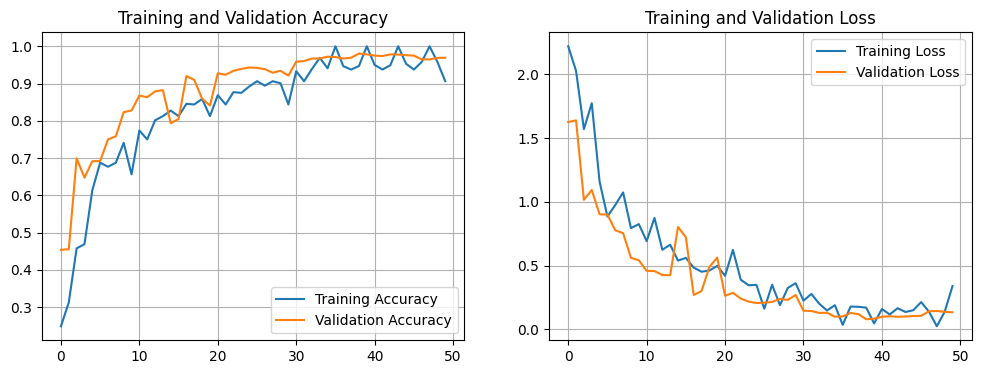

In [21]:
# --- 13. Plot Akurasi dan Loss Model ---
print("\n--- 13. Membuat Plot Akurasi dan Loss ---")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

In [22]:
# --- 14. Evaluasi Akurasi Akhir (Train, Validation, dan TEST SET) ---
print("\n--- 14. Mengevaluasi Akurasi Model ---")
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(validation_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Akurasi pada Training Set: {train_accuracy * 100:.2f}%")
print(f"Akurasi pada Validation Set: {val_accuracy * 100:.2f}%")
print(f"Akurasi pada Testing Set: {test_accuracy * 100:.2f}%")

if train_accuracy * 100 >= 85 and test_accuracy * 100 >= 85:
    print("Kriteria Akurasi (min 85%) TERPENUHI!")
else:
    print("Kriteria Akurasi (min 85%) BELUM TERPENUHI. Pertimbangkan tuning model atau augmentasi data.")
if train_accuracy * 100 >= 95 and test_accuracy * 100 >= 95:
    print("Saran: Akurasi sudah mencapai >= 95% untuk nilai tinggi!")


--- 14. Mengevaluasi Akurasi Model ---
450/450 ━━━━━━━━━━━━━━━━━━━━ 178s 396ms/step - accuracy: 0.9790 - loss: 0.0765
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9801 - loss: 0.0784
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9811 - loss: 0.0567
Akurasi pada Training Set: 98.00%
Akurasi pada Validation Set: 98.00%
Akurasi pada Testing Set: 97.72%
Kriteria Akurasi (min 85%) TERPENUHI!
Saran: Akurasi sudah mencapai >= 95% untuk nilai tinggi!



--- 16. Melakukan Contoh Inferensi ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step


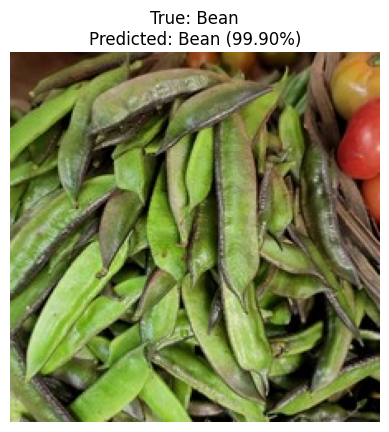

Gambar yang diprediksi: Bean
Kelas sebenarnya: Bean


In [23]:
# --- 15. Contoh Inferensi ---
print("\n--- 16. Melakukan Contoh Inferensi ---")
try:
    images_batch_inference, labels_batch_inference = next(test_generator)
    sample_image_inference = images_batch_inference[0]
    sample_label_inference = labels_batch_inference[0]

    input_image_inference = np.expand_dims(sample_image_inference, axis=0)
    predictions_inference = model.predict(input_image_inference)
    predicted_class_index_inference = np.argmax(predictions_inference[0])
    true_class_index_inference = np.argmax(sample_label_inference)

    class_labels_inference = list(train_generator.class_indices.keys())
    predicted_class_name_inference = class_labels_inference[predicted_class_index_inference]
    true_class_name_inference = class_labels_inference[true_class_index_inference]

    plt.imshow(sample_image_inference)
    plt.title(f"True: {true_class_name_inference}\nPredicted: {predicted_class_name_inference} ({predictions_inference[0][predicted_class_index_inference]*100:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"Gambar yang diprediksi: {predicted_class_name_inference}")
    print(f"Kelas sebenarnya: {true_class_name_inference}")

except StopIteration:
    print("Tidak ada lagi gambar di generator untuk inferensi.")
except Exception as e:
    print(f"Terjadi kesalahan saat melakukan inferensi: {e}")


In [24]:
# --- 15. Menyimpan Model ke Berbagai Format dan Struktur Direktori ---
print("\n--- 15. Menyimpan Model ke Berbagai Format dan Struktur Direktori ---")

submission_dir = 'submission'
os.makedirs(submission_dir, exist_ok=True)
os.makedirs(os.path.join(submission_dir, "tfjs_model"), exist_ok=True)
os.makedirs(os.path.join(submission_dir, "tflite"), exist_ok=True)
os.makedirs(os.path.join(submission_dir, "saved_model"), exist_ok=True)

# a. Menyimpan dalam format SavedModel
saved_model_path = os.path.join(submission_dir, 'saved_model')
tf.saved_model.save(model, saved_model_path)
print(f"Model berhasil disimpan dalam format SavedModel di: {saved_model_path}")

# b. Menyimpan dalam format TF-Lite
tflite_dir = os.path.join(submission_dir, 'tflite')
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model_content = converter.convert()
tflite_model_path = os.path.join(tflite_dir, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model_content)
print(f"Model berhasil disimpan dalam format TF-Lite di: {tflite_model_path}")

# Simpan label.txt untuk TF-Lite (Dinamis dari train_generator)
label_file_path = os.path.join(tflite_dir, 'label.txt')
class_labels_for_tflite = sorted(train_generator.class_indices.keys(), key=lambda x: train_generator.class_indices[x])
with open(label_file_path, 'w') as f:
    for label in class_labels_for_tflite:
        f.write(label + '\n')
print(f"Label berhasil disimpan di: {label_file_path}")

# c. Menyimpan dalam format TFJS (TensorFlow.js)
tfjs_model_dir = os.path.join(submission_dir, 'tfjs_model')
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print(f"Model berhasil disimpan dalam format TFJS di: {tfjs_model_dir}")

print("\nProses penyimpanan model selesai. Struktur direktori submission Anda kini siap.")


--- 15. Menyimpan Model ke Berbagai Format dan Struktur Direktori ---
Model berhasil disimpan dalam format SavedModel di: submission/saved_model


Model berhasil disimpan dalam format TF-Lite di: submission/tflite/model.tflite
Label berhasil disimpan di: submission/tflite/label.txt
failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil disimpan dalam format TFJS di: submission/tfjs_model

Proses penyimpanan model selesai. Struktur direktori submission Anda kini siap.


In [25]:
# --- 17. Finalisasi Submission Folder (Salin Notebook, Buat README, Requirements) ---
print("\n--- 17. Finalisasi Folder Submission ---")

%cd /content/

notebook_name = 'KLASIFIKASI_GAMBAR_VEGETABLE.ipynb' # <<<<< PASTIKAN NAMA INI SAMA DENGAN NAMA FILE IPYNB ANDA
if os.path.exists(notebook_name):
    shutil.copy(notebook_name, os.path.join(submission_dir, 'notebook.ipynb'))
    print(f"'{notebook_name}' berhasil disalin ke '{submission_dir}/notebook.ipynb'")
else:
    print(f"Peringatan: File notebook '{notebook_name}' tidak ditemukan. Tidak dapat menyalinnya. Pastikan nama file sudah benar.")

readme_path = os.path.join(submission_dir, 'README.md')
with open(readme_path, 'w') as f:
    f.write("# Proyek Klasifikasi Gambar Sayuran\n\n")
    f.write("Dataset: Vegetable Image Dataset dari Kaggle\n")
    # Akurasi akan diisi setelah pelatihan, nilai placeholder sementara
    f.write(f"Akurasi Training Set: [AKAN DIISI SETELAH PELATIHAN]%\n")
    f.write(f"Akurasi Validation Set: [AKAN DIISI SETELAH PELATIHAN]%\n")
    f.write(f"Akurasi Testing Set: [AKAN DIISI SETELAH PELATIHAN]%\n\n")
    f.write("### Struktur Direktori:\n")
    f.write("- `tfjs_model/`: Model dalam format TensorFlow.js\n")
    f.write("- `tflite/`: Model dalam format TensorFlow Lite (dengan label.txt)\n")
    f.write("- `saved_model/`: Model dalam format TensorFlow SavedModel\n")
    f.write("- `notebook.ipynb`: Jupyter Notebook yang berisi kode proyek\n")
    f.write("- `README.md`: Berkas penjelasan proyek\n")
    f.write("- `requirements.txt`: Daftar dependensi Python\n")
    f.write("\n### Cara Menggunakan (Contoh):\n")
    f.write("1. Pastikan Anda memiliki Python 3 dan TensorFlow terinstal.\n")
    f.write("2. Unduh dataset.\n")
    f.write("3. Jalankan `notebook.ipynb` untuk melatih dan mengevaluasi model.\n")
    f.write("4. Model yang sudah terlatih tersedia dalam berbagai format untuk deployment.\n")
print(f"File '{readme_path}' berhasil dibuat/diperbarui.")

requirements_path = os.path.join(submission_dir, 'requirements.txt')
!pip freeze > {requirements_path}
print(f"File '{requirements_path}' berhasil dibuat/diperbarui.")

print("\nSemua file pendukung sudah ditempatkan di folder 'submission'.")
print("Sekarang Anda dapat mengunduh folder 'submission' dalam format ZIP.")

# --- 18. Mengkompres dan Mengunduh Folder Submission ---
print("\n--- 18. Mengkompres dan Mengunduh Folder Submission ---")

!zip -r -q {submission_dir}.zip {submission_dir}/

print(f"Folder '{submission_dir}' telah berhasil dikompres menjadi {submission_dir}.zip")
print(f"Silakan REFRESH panel Files di sebelah kiri Colab, lalu klik kanan pada {submission_dir}.zip dan pilih 'Download'.")


--- 17. Finalisasi Folder Submission ---
/content
Peringatan: File notebook 'KLASIFIKASI_GAMBAR_VEGETABLE.ipynb' tidak ditemukan. Tidak dapat menyalinnya. Pastikan nama file sudah benar.
File 'submission/README.md' berhasil dibuat/diperbarui.
File 'submission/requirements.txt' berhasil dibuat/diperbarui.

Semua file pendukung sudah ditempatkan di folder 'submission'.
Sekarang Anda dapat mengunduh folder 'submission' dalam format ZIP.

--- 18. Mengkompres dan Mengunduh Folder Submission ---
Folder 'submission' telah berhasil dikompres menjadi submission.zip
Silakan REFRESH panel Files di sebelah kiri Colab, lalu klik kanan pada submission.zip dan pilih 'Download'.
